In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from pathlib import Path
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [12, 8]


---
## 1. Подготовка датасета для YOLO


Изображений: 9383
Масок: 9383


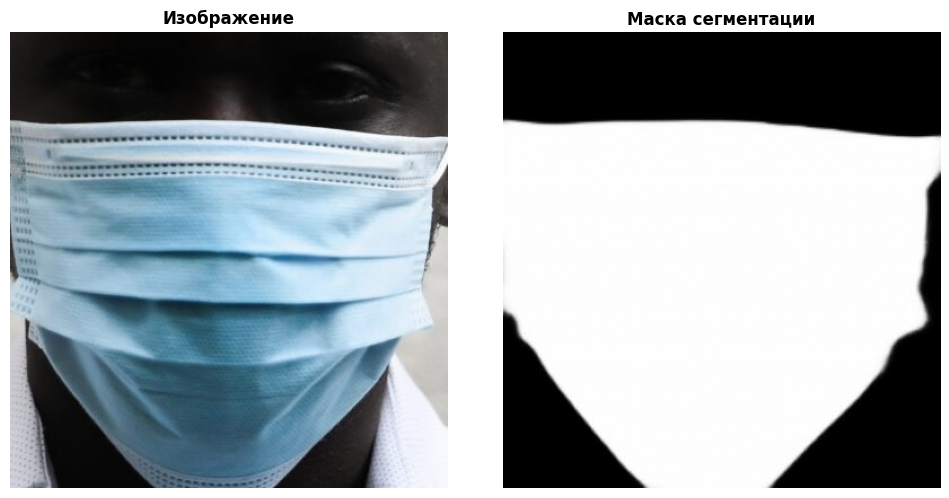

In [4]:
# Пути к данным
IMAGES_DIR = Path('MSFD/1/face_crop')
MASKS_DIR = Path('MSFD/1/face_crop_segmentation')
OUTPUT_DIR = Path('dataset_yolo')

# Проверяем данные
images = sorted(list(IMAGES_DIR.glob('*.jpg')))
masks = sorted(list(MASKS_DIR.glob('*.jpg')))

print(f'Изображений: {len(images)}')
print(f'Масок: {len(masks)}')

# Пример
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
img = cv2.imread(str(images[0]))
mask = cv2.imread(str(masks[0]), cv2.IMREAD_GRAYSCALE)

axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title('Изображение', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(mask, cmap='gray')
axes[1].set_title('Маска сегментации', fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [5]:
def mask_to_yolo_polygon(mask_path, class_id=0):
    """
    Конвертирует бинарную маску в YOLO формат полигонов.
    Возвращает строку: class_id x1 y1 x2 y2 ... (нормализованные координаты)
    """
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return None
    
    h, w = mask.shape
    
    # Бинаризация
    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    # Находим контуры
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None
    
    # Берём самый большой контур
    largest = max(contours, key=cv2.contourArea)
    
    # Минимум 3 точки для полигона
    if len(largest) < 3:
        return None
    
    # Упрощаем контур (меньше точек)
    epsilon = 0.005 * cv2.arcLength(largest, True)
    approx = cv2.approxPolyDP(largest, epsilon, True)
    
    if len(approx) < 3:
        approx = largest
    
    # Нормализуем координаты [0, 1]
    points = approx.reshape(-1, 2)
    normalized = []
    for x, y in points:
        normalized.extend([x / w, y / h])
    
    # Формат: class_id x1 y1 x2 y2 ...
    coords = ' '.join([f'{v:.6f}' for v in normalized])
    return f'{class_id} {coords}'

# Тест
test_label = mask_to_yolo_polygon(masks[0])
print('Пример YOLO метки:')
print(test_label[:100] + '...')


Пример YOLO метки:
0 0.000000 0.195062 0.000000 0.609877 0.324742 0.997531 0.608247 0.997531 0.863402 0.743210 0.889175...


In [6]:
# Создаём структуру папок YOLO
def create_yolo_dataset(images_dir, masks_dir, output_dir, train_ratio=0.8):
    """
    Создаёт датасет в формате YOLO:
    dataset_yolo/
      train/
        images/
        labels/
      val/
        images/
        labels/
    """
    output = Path(output_dir)
    
    # Очищаем если существует
    if output.exists():
        shutil.rmtree(output)
    
    # Создаём папки
    for split in ['train', 'val']:
        (output / split / 'images').mkdir(parents=True)
        (output / split / 'labels').mkdir(parents=True)
    
    # Получаем список файлов
    images = sorted(list(Path(images_dir).glob('*.jpg')))
    
    # Перемешиваем
    np.random.seed(42)
    indices = np.random.permutation(len(images))
    
    train_size = int(len(images) * train_ratio)
    train_idx = indices[:train_size]
    val_idx = indices[train_size:]
    
    stats = {'train': 0, 'val': 0, 'skipped': 0}
    
    for split, idx_list in [('train', train_idx), ('val', val_idx)]:
        for idx in tqdm(idx_list, desc=f'{split}'):
            img_path = images[idx]
            mask_path = Path(masks_dir) / img_path.name
            
            if not mask_path.exists():
                stats['skipped'] += 1
                continue
            
            # Конвертируем маску
            label = mask_to_yolo_polygon(mask_path)
            if label is None:
                stats['skipped'] += 1
                continue
            
            # Копируем изображение
            shutil.copy(img_path, output / split / 'images' / img_path.name)
            
            # Сохраняем метку
            label_name = img_path.stem + '.txt'
            with open(output / split / 'labels' / label_name, 'w') as f:
                f.write(label)
            
            stats[split] += 1
    
    return stats

print('Создание датасета YOLO...')
stats = create_yolo_dataset(IMAGES_DIR, MASKS_DIR, OUTPUT_DIR)
print(f'\nГотово!')
print(f"Train: {stats['train']}")
print(f"Val: {stats['val']}")
print(f"Пропущено: {stats['skipped']}")


Создание датасета YOLO...


val: 100%|██████████| 1877/1877 [00:21<00:00, 86.80it/s] 


Готово!
Train: 7502
Val: 1877
Пропущено: 4


In [7]:
# Создаём конфиг датасета
dataset_yaml = f"""path: {OUTPUT_DIR.absolute()}
train: train/images
val: val/images

names:
  0: mask
"""

with open(OUTPUT_DIR / 'dataset.yaml', 'w') as f:
    f.write(dataset_yaml.strip())

print('dataset.yaml создан:')
print(dataset_yaml)


dataset.yaml создан:
path: e:\proga\ImageProcessing\Practice_9-10\dataset_yolo
train: train/images
val: val/images

names:
  0: mask



---
## 2. Обучение YOLO11-seg


In [8]:
from ultralytics import YOLO

# Загружаем предобученную модель
model = YOLO('yolo11n-seg.pt')  # nano версия (быстрая)

print('Модель YOLO11n-seg загружена!')


Модель YOLO11n-seg загружена!


In [9]:
# Обучение (можно изменить параметры)
results = model.train(
    data=str(OUTPUT_DIR / 'dataset.yaml'),
    epochs=30,           # Количество эпох
    imgsz=640,           # Размер изображения
    batch=8,             # Размер батча (уменьшить если мало памяти)
    patience=10,         # Early stopping
    device=0,            # GPU (или 'cpu' если нет GPU)
    workers=2,
    project='runs',
    name='mask_seg'
)


Ultralytics 8.3.240  Python-3.10.11 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_yolo\dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mask_seg3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots

---
## 3. Тестирование модели


In [11]:
# Загружаем лучшую модель после обучения
best_model = YOLO('runs/mask_seg3/weights/best.pt')
print('Лучшая модель загружена!')


Лучшая модель загружена!


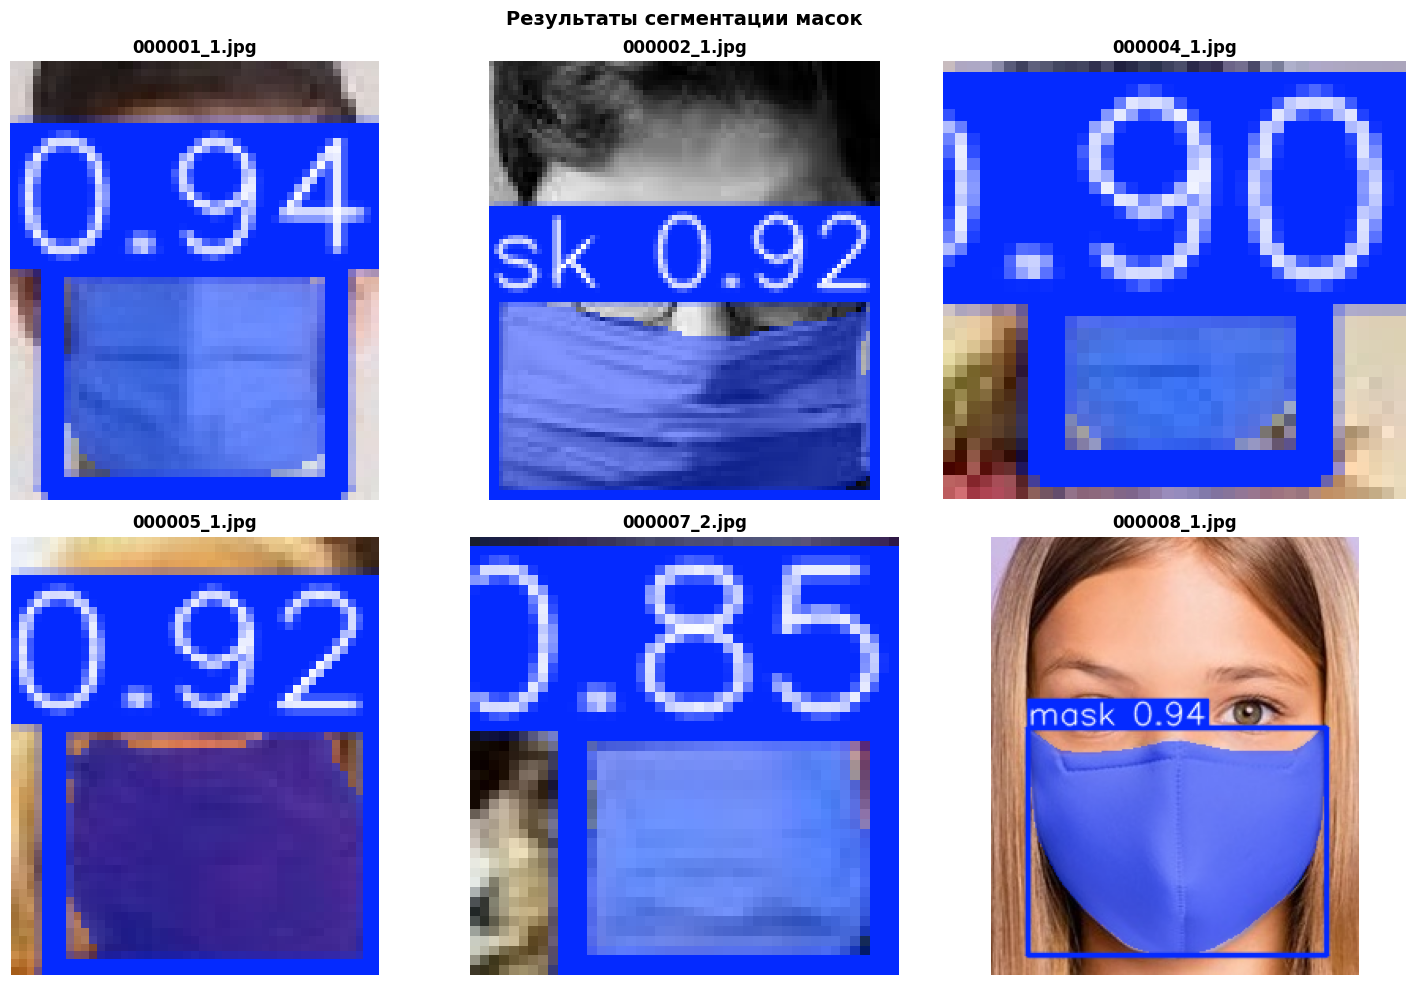

In [12]:
# Тест на валидационных изображениях
val_images = list((OUTPUT_DIR / 'val' / 'images').glob('*.jpg'))[:6]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, img_path in enumerate(val_images):
    results = best_model(str(img_path), verbose=False)
    result_img = results[0].plot()
    axes[idx].imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
    axes[idx].set_title(img_path.name, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Результаты сегментации масок', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


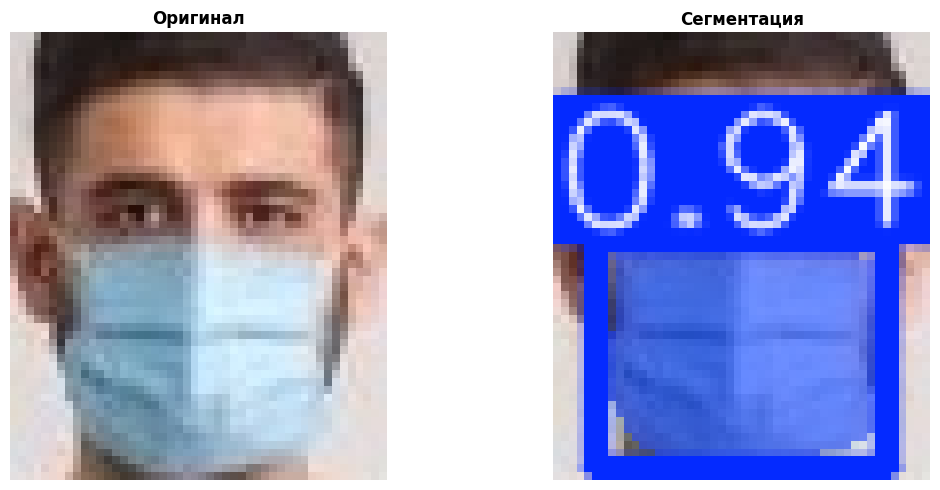

Найдено масок: 1


In [13]:
# Функция для предсказания на любом изображении
def predict_mask(image_path, conf=0.5):
    """Сегментация маски на произвольном изображении"""
    results = best_model(str(image_path), conf=conf, verbose=False)
    
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result_img = cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(img_rgb)
    axes[0].set_title('Оригинал', fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(result_img)
    axes[1].set_title('Сегментация', fontweight='bold')
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    n_masks = len(results[0].boxes) if results[0].boxes is not None else 0
    print(f'Найдено масок: {n_masks}')

# Тест
predict_mask(val_images[0])



--- 114827560_612637226347903_2763860821287827135_n.jpg ---


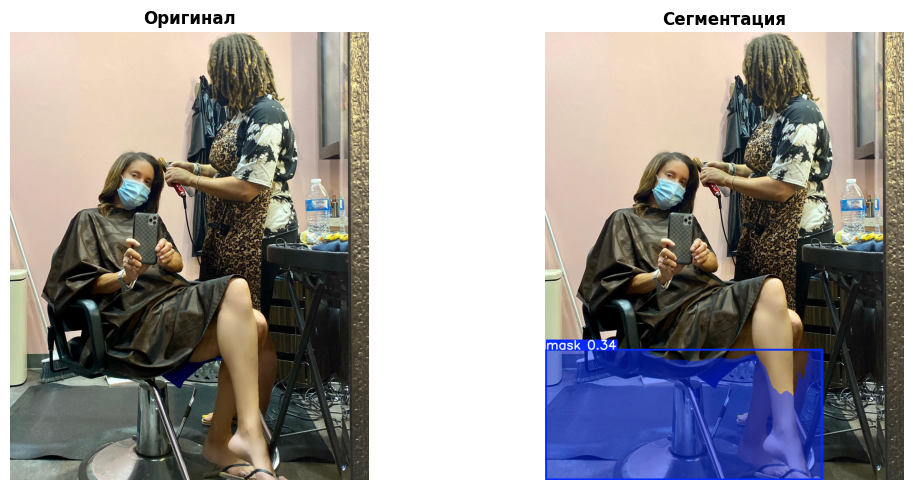

Найдено масок: 1

--- 1234carlton_130217032_1269039916807375_8534704696144444690_n.jpg ---


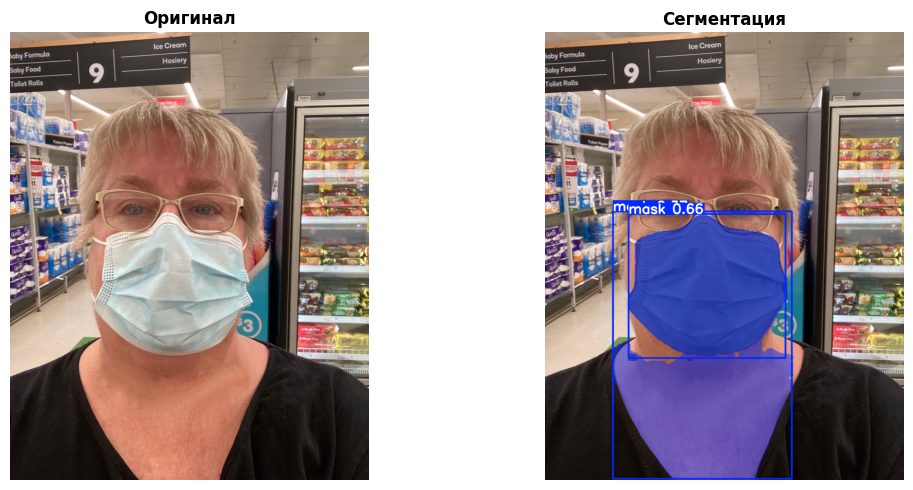

Найдено масок: 2

--- 129421898_393248228586637_4979851665036615942_n.jpg ---


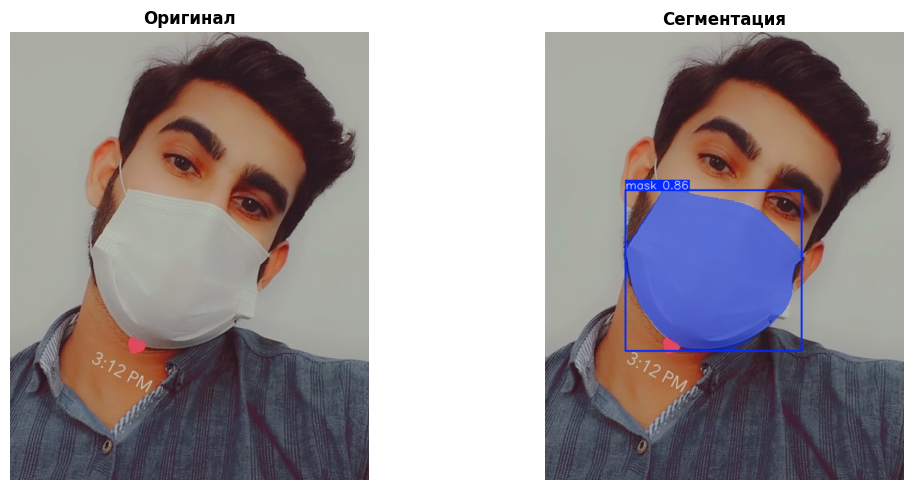

Найдено масок: 1


In [14]:
# Тест на изображениях из папки 2 (другие данные)
other_images = list(Path('MSFD/2/img').glob('*.jpg'))[:3]

for img_path in other_images:
    print(f'\n--- {img_path.name} ---')
    predict_mask(img_path, conf=0.3)
